In [2]:
# ADATA
import scanpy as sc

# NETWORK
import pandas as pd
import os

# MOTIFS

import numpy as np
from cytoolz import compose
import operator as op
import os
from os import listdir

from pyscenic.utils import load_motifs # Load motifs from step 2
from pyscenic.transform import df2regulons # Used in regulon creation in derive_regulon custom function

# AUCELL 
import json
import zlib
import base64
import loompy as lp
import pandas as pd

# ADATA EXPORT
from pyscenic.export import export2loom, add_scenic_metadata

In [9]:
DATA_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/Integration/adata/adata_scanvi_predictions.h5ad"
MODULE_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/01Networks/"
MOTIFS_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/03Motifs/"
DB_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/Common_files/databases"
AUCELL_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/04AUCell/"
SAVING_DIR = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/Results"

# ADATA 

In [4]:
adata_orig = sc.read_h5ad(DATA_DIR)
adata_orig.obs['cell_type'] = adata_orig.obs.GennAnno_ScAnvi

In [5]:
adatas = {}

In [6]:
import pickle

In [7]:
for t_type in adata_orig.obs['subtype'].cat.categories:
    ad_tum = adata_orig[adata_orig.obs['subtype'] == t_type,:].copy()
    adatas[t_type] = ad_tum

In [8]:
adatas.keys()

dict_keys(['ER', 'HER2', 'TNBC'])

In [10]:
adata_dir = os.path.join(SAVING_DIR, "adatas_dict.pkl")
with open(adata_dir, "wb") as f:
    pickle.dump(adatas, f)

# MODULES

Gene modules are genes that show co-expression across cells in the dataset ( TF + gene). 

The strenght of that co-expression is measured by the column "importance"

In [11]:
modules = {}
for t_type in adata_orig.obs['subtype'].cat.categories:
    mod_dir = os.path.join(MODULE_DIR, f"{t_type}_network.tsv")
    mod_tum = pd.read_table(mod_dir, sep = "\t")
    modules[t_type] = mod_tum

In [12]:
for module in modules.values():
    print(f"Nº of modules {module.shape[0]}")

Nº of modules 1317005
Nº of modules 1317033
Nº of modules 1411858


In [13]:
modules_dir = os.path.join(SAVING_DIR, "modules_dict.pkl")
with open(modules_dir, "wb") as f:
    pickle.dump(modules, f)

# REGULONS

Regulons are sets of genes which share regulatory sequences to which a certain TF binds to. 


## Motifs

In [14]:
motifs = {}
for t_type in adata_orig.obs['subtype'].cat.categories:
    motifs_fname = os.path.join(MOTIFS_DIR, f"{t_type}_regulons.csv")
    motif_tum = load_motifs(motifs_fname)
    motifs[t_type] = motif_tum

In [15]:
motifs.keys()

dict_keys(['ER', 'HER2', 'TNBC'])

In [16]:
def contains(*elems):
    def f(context):
        return any(elem in context for elem in elems)
    return f

In [17]:
cis_target_data = {}
for file in listdir(DB_DIR):
    if file.endswith(".feather"):
        cis_target_data[file] = pd.read_feather(os.path.join(DB_DIR,file))  

databases_names = list(cis_target_data.keys())
databases_names = [os.path.splitext(filename)[0] for filename in databases_names] 
databases_names

['hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings',
 'hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings',
 'hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.scores',
 'hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.scores']

In [18]:
def derive_regulons(motifs, db_names=databases_names):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                           & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))


In [19]:
regulons = {}
for key in motifs.keys():
    motif_tum = motifs[key]
    regulon_tum = derive_regulons(motif_tum)
    regulons[key] = regulon_tum

/tmp/ipykernel_378676/2029404592.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
/tmp/ipykernel_378676/2029404592.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
/tmp/ipyk

Create regulons from a dataframe of enriched features.
Additional columns saved: []


/tmp/ipykernel_378676/2029404592.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
/tmp/ipykernel_378676/2029404592.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
/tmp/ipyk

Create regulons from a dataframe of enriched features.
Additional columns saved: []


/tmp/ipykernel_378676/2029404592.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
/tmp/ipykernel_378676/2029404592.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
/tmp/ipyk

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [21]:
regulons_dir = os.path.join(SAVING_DIR, "regulons_dict.pkl")
with open(regulons_dir, "wb") as f:
    pickle.dump(regulons, f)

# AUCELL

In [22]:
aucells = {}
for t_type in adata_orig.obs['subtype'].cat.categories:
    aucell_fname = os.path.join(AUCELL_DIR, f"{t_type}_aucell.loom")
    
    lf = lp.connect(aucell_fname, mode='r+', validate=False )
    auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
    lf.close()

    aucells[t_type] = auc_mtx

In [ ]:
aucells

In [23]:
au_dir = os.path.join(SAVING_DIR, "aucells_dict.pkl")
with open(au_dir, "wb") as f:
    pickle.dump(aucells, f)

# ADD TO ADATA PIPELINE

In [24]:
for key in adata_orig.obs.subtype.cat.categories:
    add_scenic_metadata(adatas[key], aucells[key], regulons[key])

In [25]:
adatas

{'ER': AnnData object with n_obs × n_vars = 61800 × 18088
     obs: 'sample', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'complexity', 'doublet_scores', 'predicted_doublets', 'n_genes', 'n_counts', 'celltypist_labels_Immune_All_High', 'celltypist_scores_Immune_All_High', 'celltypist_labels_Cells_Adult_Breast', 'celltypist_scores_Cells_Adult_Breast', 'batch', 'subtype', 'leiden', 'celltypist_labels_Immune_All_High_highconf', 'GenAnno', 'GenAnnoV1', 'GenAnnoV2', 'celltypist_mapped', 'GenAnnoHighConf', 'cell_type', 'predicted_labels', 'GennAnno_ScAnvi', 'Regulon(ALX3(+))', 'Regulon(AR(+))', 'Regulon(ARID5B(+))', 'Regulon(ASCL1(+))', 'Regulon(ATF3(+))', 'Regulon(ATF4(+))', 'Regulon(ATF5(+))', 'Regulon(BACH1(+))', 'Regulon(BATF(+))', 'Regulon(BCL11A(+))', 'Regulon(BCL11B(+))', 'Regulon(BCL6(+))', 'Regulon(BCL6B(+))', 'Regulon(BHLHE41(+))', 

In [26]:
adata_dir = os.path.join(SAVING_DIR, "adatas_processed_dict.pkl")
with open(adata_dir, "wb") as f:
    pickle.dump(adatas, f)

In [27]:
df_results_dict = {}

for adata in adatas.values():
    df_obs = adata.obs
    signature_column_names = list(df_obs.select_dtypes('number').columns)
    signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
    df_scores = df_obs[signature_column_names + ['cell_type']]
    df_results = ((df_scores.groupby(by='cell_type').mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
    df_results['regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
    df_results = df_results[(df_results.Z >= 3)].sort_values('Z', ascending=False)
    df_results.regulon = df_results.regulon.str.replace(r'\(\+\)', '', regex=True)
    ttype = adata.obs.subtype.cat.categories[0]
    df_results_dict[ttype] = df_results

In [28]:
df_dir = os.path.join(SAVING_DIR, "df_results_dict.pkl")
with open(df_dir, "wb") as f:
    pickle.dump(df_results_dict, f)

In [ ]:
df = df_results_dict['TNBC'].reset_index(drop=True)
df.rename(columns={'regulon': 'TF'}, inplace=True)


In [ ]:
df.iloc[:, :2].to_csv("/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/cpdb/activetf.tsv", sep = '\t', index = False)

In [ ]:
df_results_dict['TNBC']

In [ ]:
ct_regulon = {}
def explore_celltype(c_type):
    for key in df_results_dict.keys():
        results = df_results_dict[key][df_results_dict[key].cell_type == c_type]
        trh = np.quantile(np.abs(results.Z.astype(float)),0.95)
        results = results[np.abs(results.Z.astype(float)) > trh]
        ct_regulon[key] = results.regulon 
    

In [ ]:
explore_celltype("Fibroblasts")

In [ ]:
ct_regulon

In [ ]:
# 1) Convert lists to sets for easy counting
for key in ct_regulon:
    ct_regulon[key] = set(ct_regulon[key])

# 2) Count occurrences
counts = defaultdict(int)
for subtype, tf_set in ct_regulon.items():
    for tf in tf_set:
        counts[tf] += 1

# 3) Classify TFs by appearance frequency
in_one, in_two, in_three = [], [], []
for tf, cnt in counts.items():
    if cnt == 1:
        in_one.append(tf)
    elif cnt == 2:
        in_two.append(tf)
    elif cnt == 3:
        in_three.append(tf)


In [ ]:
print("TFs in exactly one subtype list:", in_one)
print("TFs in exactly two subtype lists:", in_two)
print("TFs in all three subtype lists:", in_three)

In [ ]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.embedding(
    adatas['TNBC'],
    basis="X_scanvi_MDE",
    color=["Regulon(SHOX2(+))", "Regulon(HIC1(+))", "ENPP1","Regulon(SMAD1(+))"],
    frameon=False,
    ncols=2,use_raw = False, cmap = "viridis", size = 8)

In [ ]:
sc.pl.dotplot(adatas['ER'], ['Regulon(MITF(+))', 'Regulon(MYC(+))', 'Regulon(DDIT3(+))',], groupby='cell_type')


In [1]:
import pickle

In [2]:
with open("/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/Results/df_results_dict.pkl", "rb") as f:
    df = pickle.load(f)

In [3]:
df

{'ER':         cell_type regulon          Z
 1191   Mast cells   GATA2  10.927799
 1345   Mast cells    TAL1   8.907119
 609   Endothelial     ERG   6.076746
 768   Endothelial   SOX17   5.653256
 643   Endothelial    HEY1   5.390032
 605   Endothelial    ELK3   5.135444
 661   Endothelial   HOXD8   5.065468
 1154   Mast cells    EBF3   4.809410
 570   Endothelial   BCL6B   4.781235
 769   Endothelial   SOX18   4.181496
 787   Endothelial    TAL1   3.882504
 188       B cells  POU2F2   3.764207
 1249   Mast cells    LYL1   3.756502
 633   Endothelial   GATA2   3.575831
 221       B cells    SPIB   3.525671
 1785      Myeloid    IRF5   3.007905,
 'HER2':         cell_type regulon         Z
 840   Endothelial   SOX18  4.638924
 682   Endothelial     ERG  4.610072
 839   Endothelial   SOX17  4.607801
 844   Endothelial    SOX7  4.041955
 677   Endothelial    ELK3  3.961117
 685   Endothelial    ETS2  3.531254
 832   Endothelial   SMAD1  3.200633
 1658  Mesenchymal    HIC1  3.070465
 1610 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [11]:
df_list = []

# Loop over each key-value pair in the dictionary
for tumor_type, df_res in df.items():
    # Make a copy so we don't alter the original
    df_tmp = df_res.copy()
    # Add a new column "tumor_type" based on the dictionary key
    df_tmp["tumor_type"] = tumor_type  
    # Collect in a list
    df_list.append(df_tmp)

In [13]:
df_merged = pd.concat(df_list, ignore_index=True)

In [14]:
df_merged

,cell_type,regulon,Z,tumor_type
0,Mast cells,GATA2,10.927799,ER
1,Mast cells,TAL1,8.907119,ER
2,Endothelial,ERG,6.076746,ER
3,Endothelial,SOX17,5.653256,ER
4,Endothelial,HEY1,5.390032,ER
5,Endothelial,ELK3,5.135444,ER
6,Endothelial,HOXD8,5.065468,ER
7,Mast cells,EBF3,4.809410,ER
8,Endothelial,BCL6B,4.781235,ER
9,Endothelial,SOX18,4.181496,ER


In [26]:
df_heatmap = (
    df_merged.sort_values('Z', ascending=False).pivot_table(
        index=["tumor_type", "cell_type"],
        columns="regulon",
        values="Z",
        aggfunc="max"  # or "mean" if you have duplicates
    )
)


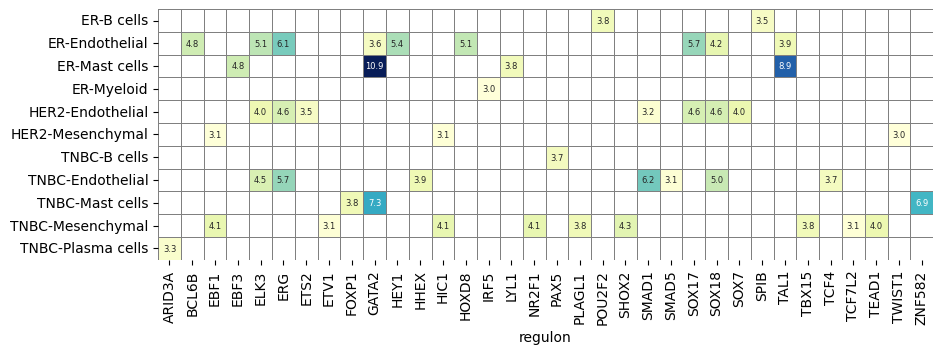

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    df_heatmap,
    ax=ax,
    annot=True,
    fmt=".1f",
    linewidths=.7,
    cbar=False,
    square=True,
    linecolor="gray",
    cmap="YlGnBu",
    annot_kws={"size": 6}
)
ax.set_ylabel("")
plt.show()

In [ ]:
from pyscenic.rss import regulon_specificity_scores

In [ ]:
rss_dict = {}

for key in adatas.keys():
    rss = regulon_specificity_scores(aucells[key], adatas[key].obs.cell_type)
    rss_dict[key] = rss

In [ ]:
rss_dict['TNBC']

In [ ]:
adata.obs['cell_type'].cat.categories

In [ ]:
from pyscenic.plotting import plot_binarization, plot_rss

In [ ]:
for rss in rss_dict.values():
    
    sns.set()
    sns.set(style='whitegrid', font_scale=0.8)
    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(8, 6), dpi=100)
    plot_rss(rss, 'B Cells', ax=ax1)
    ax1.set_xlabel('')
    plot_rss(rss, 'TCells', ax=ax2)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    plot_rss(rss, 'Fibroblasts', ax=ax3)
    ax3.set_xlabel('')
    ax3.set_ylabel('')
    plot_rss(rss, 'Epithelial', ax=ax4)
    ax4.set_xlabel('')
    ax4.set_ylabel('')
    plot_rss(rss, 'PlasmaCells', ax=ax5)
    plot_rss(rss, 'CyclingEpithelial', ax=ax6)
    ax6.set_ylabel('')
    plot_rss(rss, 'MastCells', ax=ax7)
    ax7.set_ylabel('')
    plot_rss(rss, 'Endothelial', ax=ax8)
    ax8.set_ylabel('')
    plt.tight_layout()

In [ ]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.embedding(
    adatas['ER'],
    basis="X_scanvi_MDE",
    color=["Regulon(POU2F2(+))","cell_type", "Regulon(E2F2(+))", "ENPP1"],
    frameon=False,
    ncols=2,use_raw = False, cmap = "viridis", size = 8)



In [ ]:
sc.pl.embedding(
    adatas['TNBC'],
    basis="X_scanvi_MDE",
    color=["Regulon(POU2F2(+))","cell_type", "Regulon(E2F2(+))", "ENPP1"],
    frameon=False,
    ncols=2,use_raw = False, cmap = "viridis", size = 8)

In [ ]:
modules['TNBC']

In [ ]:
modules['TNBC'][modules['TNBC'].target == "ENPP1"].sort_values('importance', ascending = False).TF.to_list()

In [ ]:
sc.pl.embedding(
    adatas['TNBC'],
    basis="X_scanvi_MDE",
    color=["cell_type", "ENPP1", "Regulon(GATA3(+))","Regulon(XBP1(+))","Regulon(ESR1(+))","Regulon(ZNF385D(+))", "Regulon(AR(+))"],
    frameon=False,
    ncols=3,use_raw = False, cmap = "viridis", size = 8)

In [ ]:
some_gene = "ENPP1"

matching_regulons = [
    r
    for r in regulons["TNBC"]
    if some_gene in r.gene2weight and isinstance(r.gene2weight[some_gene], float)
]

In [ ]:
matching_regulons

In [ ]:
some_tf = "AEBP1"
match = next((r for r in regulons['TNBC'] if r.name == some_tf), None)

if match is not None:
    print(f"Regulon found for TF '{some_tf}': {match.name}")
else:
    print(f"No regulon found for TF '{some_tf}'")

In [ ]:
match.name

In [ ]:
[regulons['TNBC'][1].name == "TRPS1"]

In [ ]:
sc.pl.embedding(
    adatas['TNBC'],
    basis="X_scanvi_MDE",
    color=["cell_type", "ENPP1", "Regulon(GATA3(+))","Regulon(XBP1(+))","Regulon(ESR1(+))","Regulon(ZNF385D(+))", "Regulon(AR(+))"],
    frameon=False,
    ncols=3,use_raw = False, cmap = "viridis", size = 8)

In [ ]:
pd.DataFrame({"barcode_sample" : adatas['TNBC'].obs_names.values,
             "cell_type" : adatas['TNBC'].obs.cell_type.values}).to_csv("/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/cpdb/metadata.tsv", sep = '\t', index = False)

# Análisis de regulones comunes

## Sacar los genes regulados por cada TF encada regulón con su importancia

In [45]:
filas = []

for subtipo, lista_regulones in regulons.items():
    for regulon in lista_regulones:
        for gen, puntaje in regulon.gene2weight.items():
            filas.append({
                'subtipo': subtipo,
                'regulon_name': regulon.name,
                'gen': gen,
                'puntaje': puntaje
            })
df_genes_regulones = pd.DataFrame(filas)


In [46]:
df_genes_regulones

,subtipo,regulon_name,gen,puntaje
0,ER,AR,LCOR,2.169366
1,ER,AR,ANKEF1,0.501753
2,ER,AR,OSBPL1A,2.136968
3,ER,AR,DENND5B,0.098241
4,ER,AR,VWA2,0.758286
...,...,...,...,...
98245,TNBC,ZSCAN31,MFSD2B,0.464917
98246,TNBC,ZSCAN31,KCNC3,0.049985
98247,TNBC,ZSCAN31,PPARGC1A,0.201516
98248,TNBC,ZSCAN31,MECOM,0.333651


## Filtrar regulones con un alto Z-score en los tipos celulares y conseguir los genes regulados por ellos con alta importancia

In [142]:
relevant_genes = {}
for tumor in df_results_dict.keys():
    df = df_results_dict[tumor]
    cell_types = df.cell_type.unique().tolist()
    
    for ct in cell_types:
        df_ct = df[df.cell_type == ct]
        
        for reg in  df_ct.regulon.unique():
            min_importance = df_genes_regulones[(df_genes_regulones.subtipo == tumor) & 
                                                (df_genes_regulones.regulon_name == reg)].puntaje.quantile(0.9)
            
            gene_list = df_genes_regulones[(df_genes_regulones.subtipo == tumor)&
                                            (df_genes_regulones.regulon_name == reg)&
                                            (df_genes_regulones.puntaje >= min_importance)].gen.tolist()

            if gene_list:
                relevant_genes[(tumor, ct, reg)] = gene_list
               

In [143]:
genes_dir = os.path.join(SAVING_DIR, "relevant_genes_dict.pkl")
with open(genes_dir, "wb") as f:
    pickle.dump(relevant_genes, f)

In [103]:
cell_types = df_results_dict['TNBC'].cell_type.cat.categories.tolist()

In [114]:
df_results_dict['TNBC'][df_results_dict['TNBC'].cell_type == cell_types[2]]

,cell_type,regulon,Z
787,Endothelial,SMAD1,6.190944
632,Endothelial,ERG,5.677251
793,Endothelial,SOX18,4.981453
629,Endothelial,ELK3,4.541414
671,Endothelial,HHEX,3.924097
816,Endothelial,TCF4,3.653893
789,Endothelial,SMAD5,3.145579


In [133]:
min_importance = df_genes_regulones[(df_genes_regulones.subtipo == "TNBC")&(df_genes_regulones.regulon_name == "SMAD5")].puntaje.quantile(0.9)
genes_analyse = df_genes_regulones[(df_genes_regulones.subtipo == "TNBC")&(df_genes_regulones.regulon_name == "SMAD5")&(df_genes_regulones.puntaje >= min_importance)].gen.tolist()

In [48]:
lista_conjuntos = [set(df.regulon) for df in df_results_dict.values()]

In [49]:
valores_comunes = set.intersection(*lista_conjuntos)

In [50]:
valores_comunes

{'ELK3', 'ERG', 'SOX18'}

In [90]:
def hallar_genes_comunes(df_genes, regulon):


    df_gen = df_genes_regulones_comunes[df_genes_regulones_comunes.regulon_name == regulon] # filtara el regulón de interés
    count_subtipos = df_gen.groupby("gen")["subtipo"].nunique() # contar en cuántos subtipos aparece
    genes_comunes = count_subtipos[count_subtipos == 3].index # filtrar solo los genes que estén en los 3 subtipos (comunes)
    
    df_genes_comunes = df_gen[df_gen["gen"].isin(genes_comunes)] # filtrar el dataframe con esos genes comunes
    df_genes_comunes.loc[:,"Zscore"] = (df_genes_comunes.puntaje - df_genes_comunes.puntaje.mean()) / df_genes_comunes.puntaje.std() # z score

    df_pivot = df_genes_comunes.pivot(index='gen', columns='subtipo', values='Zscore') 

    df_positivos = df_pivot[(df_pivot > 0).all(axis=1)]

    return(df_positivos)

In [91]:
comunes_ELK3 = hallar_genes_comunes(df_genes_regulones, "ELK3")
comunes_ERG = hallar_genes_comunes(df_genes_regulones, "ERG")
comunes_SOX18 = hallar_genes_comunes(df_genes_regulones, "SOX18")

/tmp/ipykernel_378676/2319008322.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genes_comunes.loc[:,"Zscore"] = (df_genes_comunes.puntaje - df_genes_comunes.puntaje.mean()) / df_genes_comunes.puntaje.std() # z score
/tmp/ipykernel_378676/2319008322.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genes_comunes.loc[:,"Zscore"] = (df_genes_comunes.puntaje - df_genes_comunes.puntaje.mean()) / df_genes_comunes.puntaje.std() # z score


In [1]:
comunes_ELK3

NameError: name 'comunes_ELK3' is not defined

## Graficar

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
df_pivot

subtipo,ER,HER2,TNBC
gen,,,
ACVRL1,-1.198479,-1.067343,0.562379
ADAMTS6,-0.794366,-0.605206,-0.170612
ADGRF5,-0.534990,0.469180,0.901561
APOLD1,-1.021380,2.056319,-0.612180
AQP1,-0.359178,0.231972,0.308994
CASKIN2,-1.229808,-0.991127,-0.808351
CD34,-0.345562,0.450912,-0.138453
CD93,2.048866,0.637169,0.071395
CDH5,0.282150,0.008313,0.343622


<Figure size 800x1000 with 0 Axes>

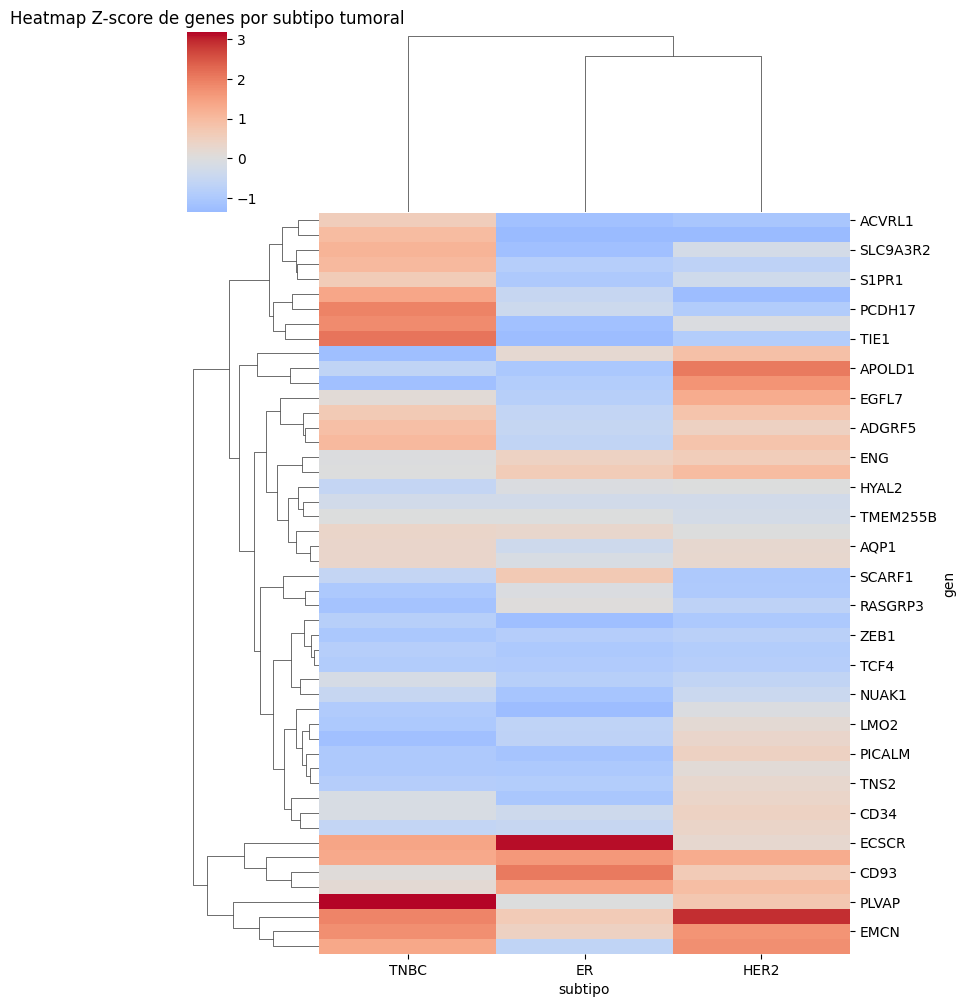

In [83]:
# 2. Crear el heatmap
plt.figure(figsize=(8, 10))  # ajusta el tamaño de la figura según necesites
clustermap = sns.clustermap(
    df_pivot,
    method="average",         # método de linkage (opcional)
    metric="euclidean",       # métrica de distancia (opcional)
    cmap="coolwarm",
    center=0,
    figsize=(8, 10)
)
# 3. Mostrar el gráfico
plt.title("Heatmap Z-score de genes por subtipo tumoral")
plt.show()